# 0 - Import of Modules

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")
from pycaret.classification import *
from pycaret.regression import *

# 1 - Data Exploration and Analysis

## 1.1 - Data Import

In [2]:
df = pd.read_excel('O&G Equipment Data.xlsx')

## 1.2 - Initial Exploration

In [3]:
df.head()

Cycle  Preset_1  Preset_2  Temperature    Pressure  VibrationX  VibrationY  \
0      1         3         6    44.235186   47.657254   46.441769   64.820327   
1      2         2         4    60.807234   63.172076   62.005951   80.714431   
2      3         2         1    79.027536   83.032190   82.642110   98.254386   
3      4         2         3    79.716242  100.508634  122.362321  121.363429   
4      5         2         5    39.989054   51.764833   42.514302   61.037910   

   VibrationZ  Frequency   Fail  
0   66.454520  44.483250  False  
1   81.246405  60.228715  False  
2   98.785196  80.993479  False  
3  118.652538  80.315567  False  
4   50.716469  64.245166  False

In [4]:
# Analyzing data types and the presence of nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Cycle        800 non-null    int64  
 1   Preset_1     800 non-null    int64  
 2   Preset_2     800 non-null    int64  
 3   Temperature  800 non-null    float64
 4   Pressure     800 non-null    float64
 5   VibrationX   800 non-null    float64
 6   VibrationY   800 non-null    float64
 7   VibrationZ   800 non-null    float64
 8   Frequency    800 non-null    float64
 9   Fail         800 non-null    bool   
dtypes: bool(1), float64(6), int64(3)
memory usage: 57.2 KB


In [5]:
# Viewing some statistical measures and the distribution of variables
df.describe()

Cycle    Preset_1    Preset_2  Temperature    Pressure  VibrationX  \
count  800.0000  800.000000  800.000000   800.000000  800.000000  800.000000   
mean   400.5000    1.988750    4.551250    69.263494   78.997945   73.860275   
std    231.0844    0.805875    2.293239    25.536252   32.501834   31.229631   
min      1.0000    1.000000    1.000000     2.089354    3.480279    3.846343   
25%    200.7500    1.000000    3.000000    51.040134   55.508564   50.752461   
50%    400.5000    2.000000    5.000000    65.906716   75.014848   69.394953   
75%    600.2500    3.000000    7.000000    80.527220   99.302530   90.195059   
max    800.0000    3.000000    8.000000   255.607829  189.995681  230.861142   

       VibrationY  VibrationZ   Frequency  
count  800.000000  800.000000  800.000000  
mean    72.786878   71.866211   68.223449  
std     32.739745   27.844616   29.138702  
min     10.057744   18.784169    4.380101  
25%     48.523982   50.787638   45.861762  
50%     65.504770   69.319237   65.664252  
75%     94.075572   88.891205   90.097457  
max    193.569947  230.951134  178.090303

In [6]:
# Separating the types of variables according to the case
parameter = ['Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']
setups = ['Preset_1', 'Preset_2']

In [7]:
# Confirming null values and observing the amount of zeros

def zero_null_count(df):
    
    float_columns = df.select_dtypes(include='float').columns.to_list()
    
    zero_c , zero_p = [], []
    null_c, null_p  = [], []
    

    for i in float_columns:
        
        zero_c.append(df[df[i] == 0].shape[0])
        zero_p.append(df[df[i] == 0].shape[0] / df.shape[0])
        null_c.append(df[df[i].isnull()].shape[0])
        null_p.append(df[df[i].isnull()].shape[0] / df.shape[0])
        
    return pd.DataFrame({'Column' : float_columns, 'Zeros' : zero_c, 'Zeros p' : zero_p, 'Null' : null_c, 'Null p' : null_p})

zero_null_count(df)

Column  Zeros  Zeros p  Null  Null p
0  Temperature      0      0.0     0     0.0
1     Pressure      0      0.0     0     0.0
2   VibrationX      0      0.0     0     0.0
3   VibrationY      0      0.0     0     0.0
4   VibrationZ      0      0.0     0     0.0
5    Frequency      0      0.0     0     0.0

In [8]:
# Analyzing the distribution of setups

df.Preset_1.value_counts(), df.Preset_2.value_counts()

(2    281
 1    264
 3    255
 Name: Preset_1, dtype: int64,
 7    109
 6    101
 3    101
 2    101
 5    100
 8    100
 1     95
 4     93
 Name: Preset_2, dtype: int64)

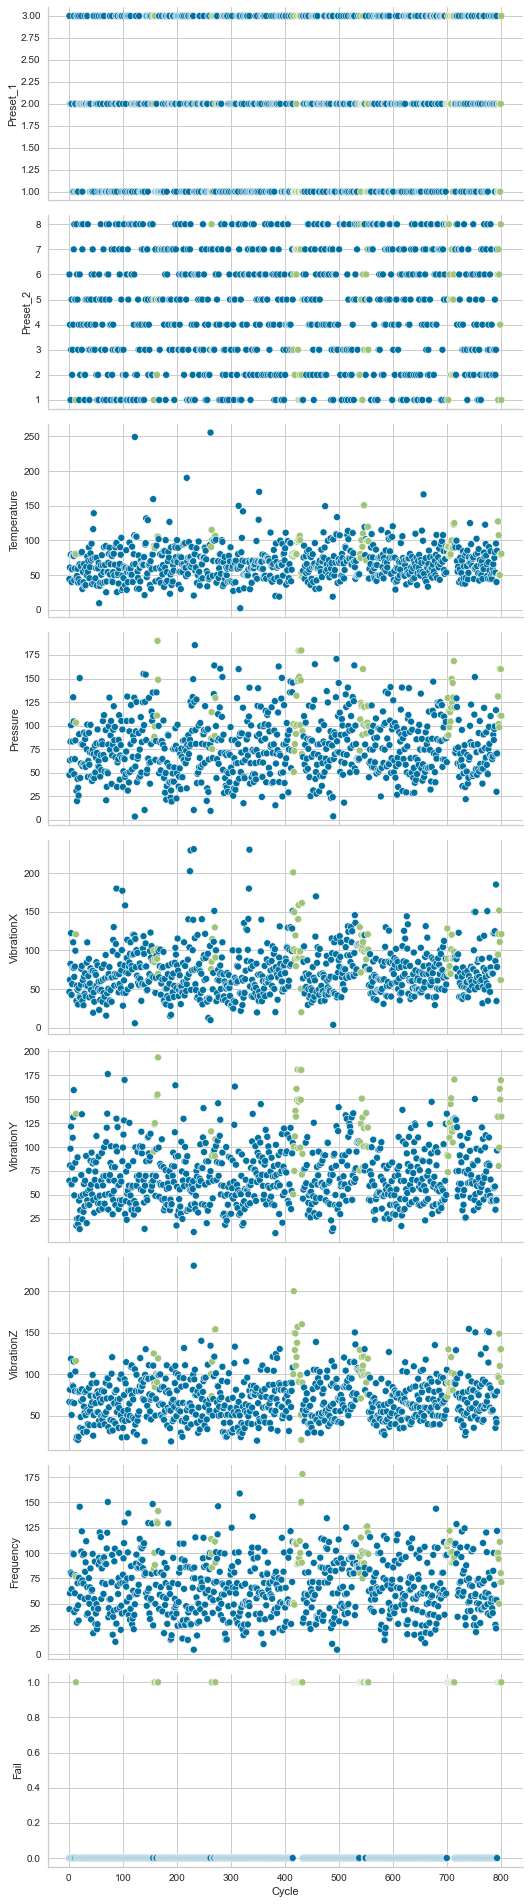

In [9]:
# As the cycle variable indicates a temporal evolution, interest is generated in evaluating the 
# evolution of other variables in relation to it.

df.sort_values(by=['Cycle'], inplace = True)

sns.PairGrid(data=df,
                 x_vars='Cycle',
                 y_vars=[i for i in df.columns if i not in ['Cycle']], size=3, aspect=2.5, hue = 'Fail').map(sns.scatterplot)

## 1.3 Reformulation of Concept in Data

In [10]:
# The arrangement of variables with the evolution of the cycle proved to be a little noisy and a 
# possible reason can be observed in the last graph. The failure of this equipment occurs at different 
# periods in time evolution. This leads to thinking about reformulating the temporal vision in periods 
# of failure.

In [11]:
# Checking the continuity of cycles

print('Continuous cycle? Answer:' , (df.Cycle.diff(1).max() == 1) == (df.Cycle.diff(1).min() == 1))

Continuous cycle? Answer: True


In [12]:
# Evaluating the failure moments in relation to the presented cycle. 
# As some failures appear continuously in the evolution of the cycle, it was considered that 
# the failures come from the same period.

df_fail = df.query('Fail == True')[['Cycle', 'Fail']]

df_fail['diff'] = df_fail.Cycle.diff()

beginning_cycle = pd.DataFrame({'Cycle' : df_fail.query('Fail == True and diff != 1').Cycle.to_list(), 
               'Cycle_Name' : [i for i in range(df_fail.query('Fail == True and diff != 1').shape[0])]})

df_fail = pd.merge(df_fail, beginning_cycle, how = 'left')

for i in range(df_fail.shape[0]):
    
    if df_fail.Cycle_Name.isnull()[i] and i != 0:
        
        df_fail.Cycle_Name.iloc[i] = df_fail.Cycle_Name.iloc[i - 1]
        
resumo_df_fail  = df_fail.groupby('Cycle_Name').Cycle.agg(['min', 'max']).reset_index().rename(columns = {'max' : 'End_Cycle'})
resumo_df_fail['Beginning_Cycle'] = resumo_df_fail['End_Cycle'].shift(1).fillna(0)
resumo_df_fail

Cycle_Name  min  End_Cycle  Beginning_Cycle
0         0.0   13         13              0.0
1         1.0  157        159             13.0
2         2.0  163        165            159.0
3         3.0  263        265            165.0
4         4.0  270        271            265.0
5         5.0  415        432            271.0
6         6.0  538        546            432.0
7         7.0  550        554            546.0
8         8.0  700        713            554.0
9         9.0  793        800            713.0

In [13]:
# From the adopted concept, it can be concluded that there are 10 failure moments

In [14]:
# Separate Cycles in which failures occur

cycles = []

for i in range(resumo_df_fail.shape[0]):
    
    if resumo_df_fail.Beginning_Cycle.iloc[i] == 0:
        
        cycles.append(df[(df.Cycle >= resumo_df_fail['Beginning_Cycle'].iloc[i]) & (df.Cycle <= resumo_df_fail['End_Cycle'].iloc[i])])
        
    else:
                     
        cycles.append(df[(df.Cycle > resumo_df_fail['Beginning_Cycle'].iloc[i]) & (df.Cycle <= resumo_df_fail['End_Cycle'].iloc[i])])

# Counting to failure helps us see how close we are to failure

for i in range(len(cycles)):
    
    cycles[i].loc[ cycles[i].Fail == False , 't_fail'] = list(range(cycles[i].query("Fail == False").shape[0], 0, -1))
    cycles[i].loc[ cycles[i].Fail == True , 't_fail'] = 0
    cycles[i]['cycle_name'] = i
    cycles[i]['cycle_len'] = cycles[i].shape[0]

In [15]:
df = pd.concat(cycles)
df.head()

Cycle  Preset_1  Preset_2  Temperature    Pressure  VibrationX  VibrationY  \
0      1         3         6    44.235186   47.657254   46.441769   64.820327   
1      2         2         4    60.807234   63.172076   62.005951   80.714431   
2      3         2         1    79.027536   83.032190   82.642110   98.254386   
3      4         2         3    79.716242  100.508634  122.362321  121.363429   
4      5         2         5    39.989054   51.764833   42.514302   61.037910   

   VibrationZ  Frequency   Fail  t_fail  cycle_name  cycle_len  
0   66.454520  44.483250  False    12.0           0         13  
1   81.246405  60.228715  False    11.0           0         13  
2   98.785196  80.993479  False    10.0           0         13  
3  118.652538  80.315567  False     9.0           0         13  
4   50.716469  64.245166  False     8.0           0         13

In [16]:
# Size of failure cycles
df.groupby('cycle_name').cycle_len.max().reset_index()

cycle_name  cycle_len
0           0         13
1           1        146
2           2          6
3           3        100
4           4          6
5           5        161
6           6        114
7           7          8
8           8        159
9           9         87

In [17]:
# Re-evaluating the variables in relation to the time to failure (t_fail)

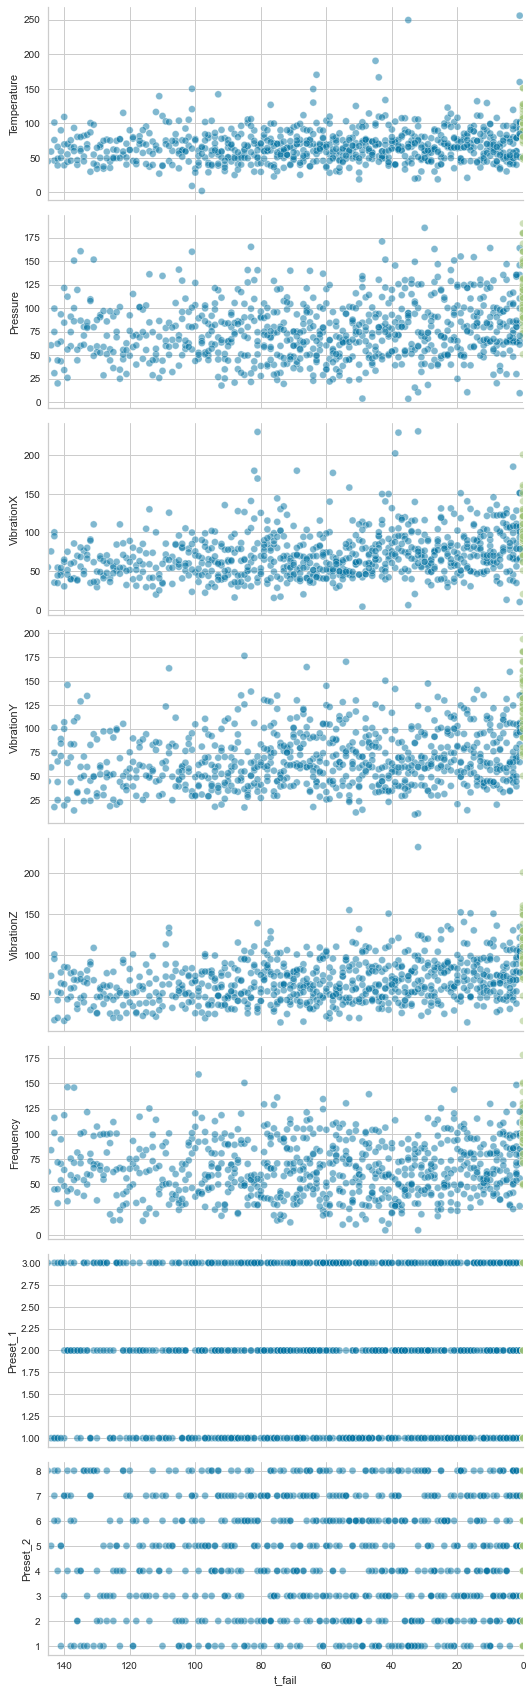

In [18]:
sns.PairGrid(data=df,
                 x_vars='t_fail',
                 y_vars=parameter + setups, 
             size=3, aspect=2.5, hue = 'Fail').map(sns.scatterplot, alpha=0.5).set(xlim=(df.t_fail.max(),0))

## 1.4 - Observing the behavior of parameter variables

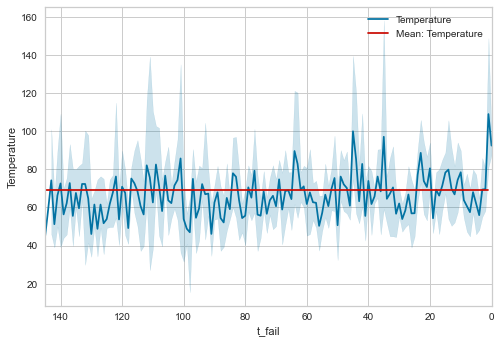

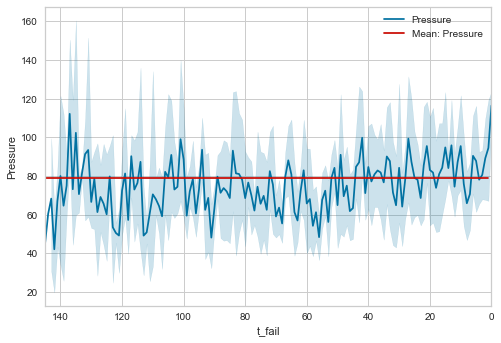

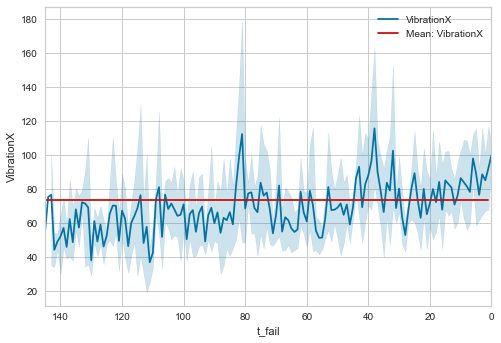

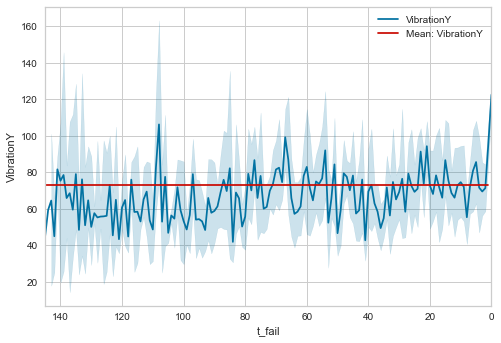

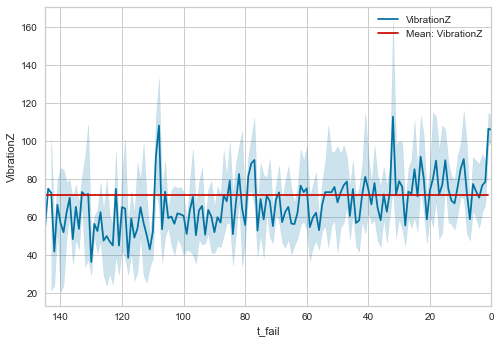

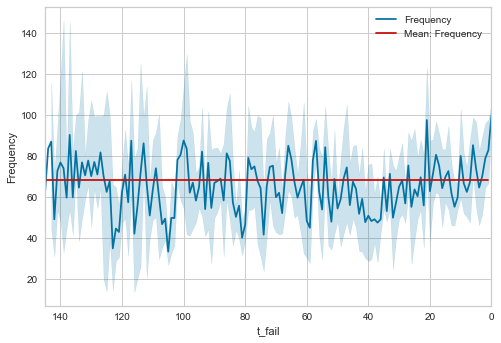

In [19]:
# Observing the behavior of the parameters in relation to their average 
# and the evolution in time until failure

for i in parameter:
    
    sns.lineplot(x="t_fail", y=i, label = i,
             data=df).set(xlim=(df.t_fail.max(),0))

    x_range = range(int(df.t_fail.max()),0,-1)
    
    sns.lineplot(x=x_range, y= [df[i].mean() for n in x_range], label = "Mean: " + i, color = 'r')
    
    plt.show()

In [20]:
# Graphically we can see that when approaching a failure, the parameters assume values 
# close to or greater than their averages.

In [21]:
# Numerically observing the distribution of parameters globally
df[parameter].describe(percentiles = [i/10 for i in range(10)])

Temperature    Pressure  VibrationX  VibrationY  VibrationZ   Frequency
count   800.000000  800.000000  800.000000  800.000000  800.000000  800.000000
mean     69.263494   78.997945   73.860275   72.786878   71.866211   68.223449
std      25.536252   32.501834   31.229631   32.739745   27.844616   29.138702
min       2.089354    3.480279    3.846343   10.057744   18.784169    4.380101
0%        2.089354    3.480279    3.846343   10.057744   18.784169    4.380101
10%      40.849732   40.163221   39.980738   35.090130   39.644190   30.468063
20%      49.232186   50.592502   48.737452   44.269247   48.564392   41.281632
30%      54.765569   59.862410   54.736339   52.039708   54.927706   49.811809
40%      60.742104   66.708991   62.015166   59.756840   61.082030   58.591836
50%      65.906716   75.014848   69.394953   65.504770   69.319237   65.664252
60%      71.325957   84.188073   77.011459   75.938790   76.473037   74.216272
70%      78.260756   93.856847   85.397989   85.929914   84.422118   85.157793
80%      88.648181  104.278068   96.398674   99.787780   94.412651   95.131961
90%     100.034122  124.501279  114.906827  119.797352  106.316236  106.174147
max     255.607829  189.995681  230.861142  193.569947  230.951134  178.090303

In [22]:
# Numerically observing the distribution of parameters when a failure occurs
df.query('Fail == True')[parameter].describe(percentiles = [i/10 for i in range(10)])

Temperature    Pressure  VibrationX  VibrationY  VibrationZ   Frequency
count    66.000000   66.000000   66.000000   66.000000   66.000000   66.000000
mean     92.469125  116.422540  100.167190  122.481159  106.003200   99.812745
std      21.683670   30.040055   28.109402   30.861777   28.377486   22.960578
min      48.091962   50.822002   20.120467   50.481820   20.522642   48.923777
0%       48.091962   50.822002   20.120467   50.481820   20.522642   48.923777
10%      73.039935   85.847585   70.629440   85.323380   79.733023   75.721720
20%      79.360314   91.127475   79.858117   95.328429   89.197182   88.779694
30%      80.336801   99.548317   89.247083  100.598692   90.308892   90.308884
40%      88.768766  101.617775   90.736002  116.079478   97.778930   94.097813
50%      90.928964  110.619156   98.043755  122.115118   99.669357   99.212676
60%      99.002490  119.991512  100.605593  130.736892  105.486312  100.598048
70%     100.473504  129.436228  108.745067  136.640171  118.966062  109.980807
80%     106.468516  147.422493  120.277637  149.739476  129.166580  111.868857
90%     121.267853  160.010666  129.915440  160.770348  149.014134  126.064010
max     150.880308  189.995681  200.749598  193.569947  200.242674  178.090303

In [23]:
# Numerically, it is possible to observe that when there is a failure, the distribution of 
# parameter values is above the general one. This is most evident by looking at the deciles.
# As it is expected a distribution curve a little more shifted to the right because of the mean and a 
# little more flattened because of the standard deviation. The following graphs are plotted:

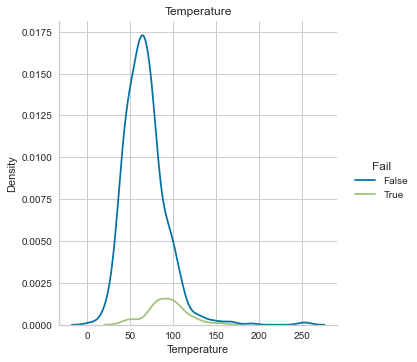

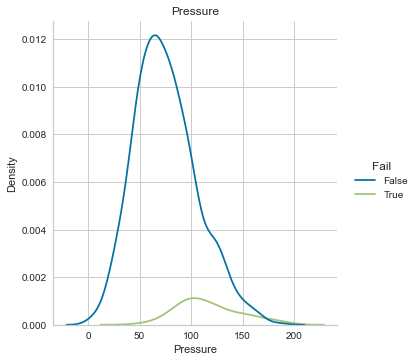

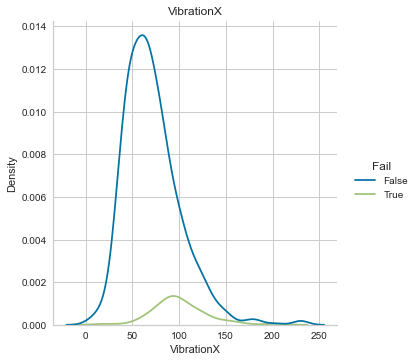

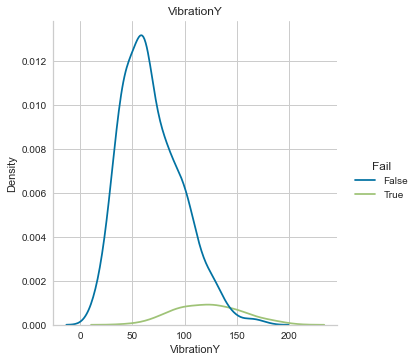

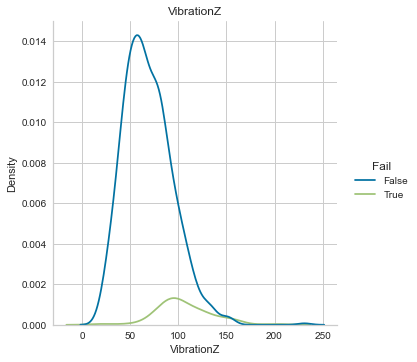

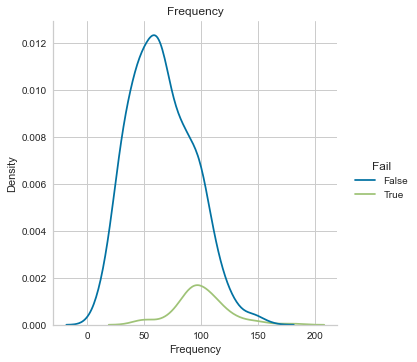

In [24]:
for i in parameter:
    
     sns.displot(df, x= i, hue="Fail", kind="kde").set(title=i)

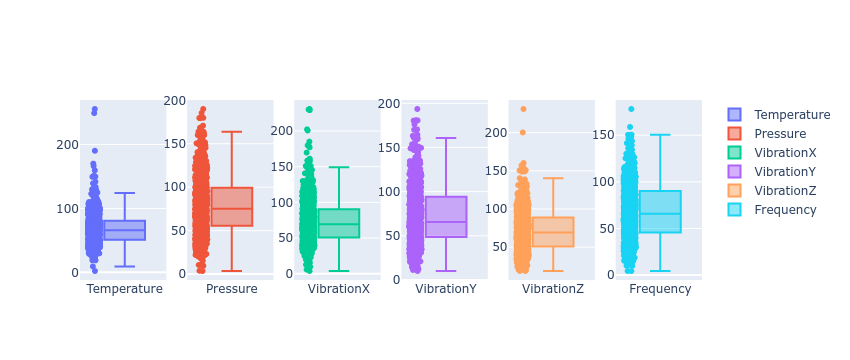

In [25]:
# Boxplot Parameters

fig = make_subplots(rows=1, cols=len(parameter))
for i, var in enumerate(parameter):
    fig.add_trace(
        go.Box(y=df[var],
        name=var),
        row=1, col=i+1
    )

fig.update_traces(boxpoints='all', jitter=.3)

In [26]:
df.query('Temperature > 124').Fail.value_counts()

False    16
True      5
Name: Fail, dtype: int64

In [27]:
df.query('Pressure > 164').Fail.value_counts()

True     5
False    3
Name: Fail, dtype: int64

In [28]:
df.query('VibrationX > 150').Fail.value_counts()

False    13
True      4
Name: Fail, dtype: int64

In [29]:
df.query('VibrationY > 150').Fail.value_counts()

True     13
False     6
Name: Fail, dtype: int64

In [30]:
df.query('VibrationZ > 140').Fail.value_counts()

True     8
False    7
Name: Fail, dtype: int64

In [31]:
df.query('Frequency > 150').Fail.value_counts()

False    2
True     2
Name: Fail, dtype: int64

In [32]:
# From the Boxplot plots we have candidates for some outliers, but when observing the distribution values
# from the describe() method, we can conclude that these candidates are not so offensive.
# Furthermore, we can see in the above queries that these candidates are linked in some cases to the effect
# that we want to understand.

## 1.5 - Observing the behavior of setups

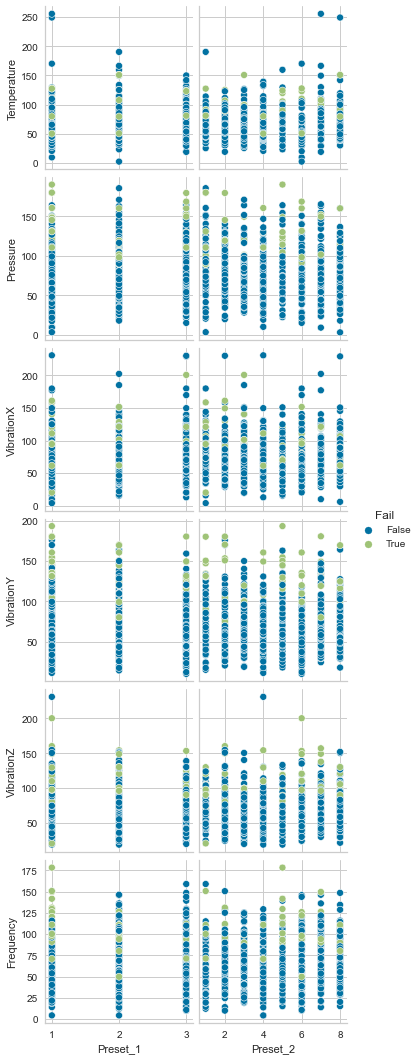

In [33]:
sns.pairplot(data=df,
                 x_vars=setups,
                 y_vars=parameter,
                 hue="Fail", aspect=1)

In [34]:
# In the graphs above, an attempt was made to relate the behavior of the parameters to the configuration 
# of the setups. It can be seen that the failures tend to be at higher values of the parameters and that 
# they are well distributed in relation to the setups values. As much as it is not evident, there are 
# indications that the setups are correlated with the number of failures. Therefore, the exploration of 
# the data continues as follows:

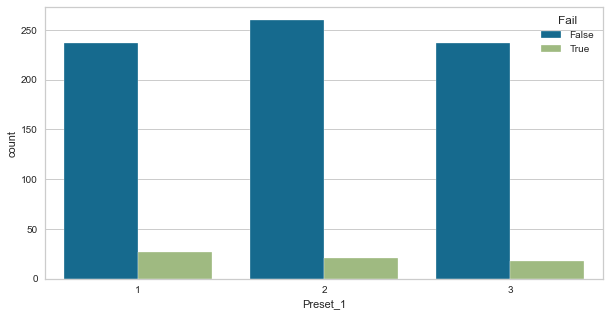

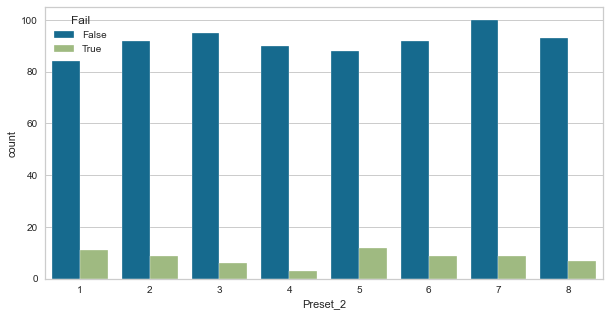

In [35]:
for i in setups:
        plt.figure(figsize=(10,5))
        sns.countplot(df[i],hue=df['Fail'])
        plt.show()

In [36]:
# It may not be causal, but some configurations have a slightly higher number of failures than others. 
# This is even more evident in Setup 2.

In [37]:
# Here, we are going to combine the setups to try to find evidence that in certain configurations 
# there are more failures.

df['set1 + set2'] = df.Preset_1.astype(str) +'_' + df.Preset_2.astype(str)

<AxesSubplot:xlabel='set1 + set2', ylabel='count'>

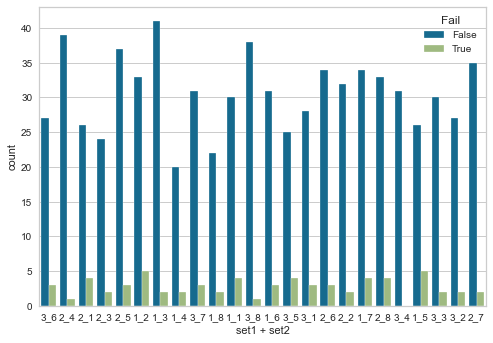

In [38]:
sns.countplot(df['set1 + set2'], hue=df['Fail'])

In [39]:
# In the graph above it can be seen that some combinations are linked to a smaller and larger number 
# of failures. This could be something highly correlated with the Fail event or with the company 
# operating on the configuration.

<AxesSubplot:xlabel='set1 + set2', ylabel='count'>

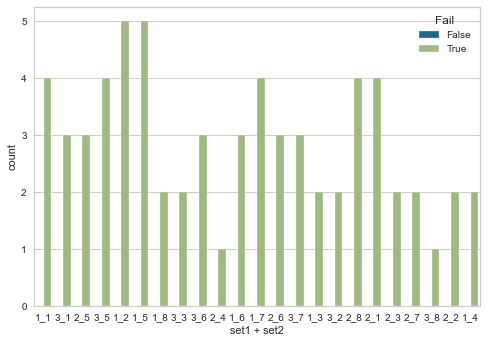

In [40]:
sns.countplot(df.query("Fail == 1")['set1 + set2'], hue=df['Fail'])

In [41]:
# More failures occur in Setup 1 with configuration 1. 
# And fewer failures occur with configuration 3.
df.query("Fail == 1").Preset_1.value_counts()

1    27
2    21
3    18
Name: Preset_1, dtype: int64

In [42]:
# More failures occur in Setup 2 with configuration 5. 
# And fewer failures occur with configuration 7, 6 and 2.
df.query("Fail == 1").Preset_2.value_counts().head(5)

5    12
1    11
2     9
6     9
7     9
Name: Preset_2, dtype: int64

In [43]:
# More failures occur when Setup 1 is set to 1 and Setup 2 is set to 5.
# And fewer failures occur when Setup 1 is set to 3 and Setup 2 is set to 8.
# The configuration of 2 for setup 1 and 4 for setup 2 also presented lower failure values.
df.query("Fail == 1")['set1 + set2'].value_counts().head(3) , df.query("Fail == 1")['set1 + set2'].value_counts().tail(3)

(1_5    5
 1_2    5
 1_1    4
 Name: set1 + set2, dtype: int64,
 1_4    2
 3_8    1
 2_4    1
 Name: set1 + set2, dtype: int64)

## 1.6 - Correlation analysis

In [44]:
# Here we seek to explore the correlation of parameters, failures, and time before failure (t_fail).

<AxesSubplot:>

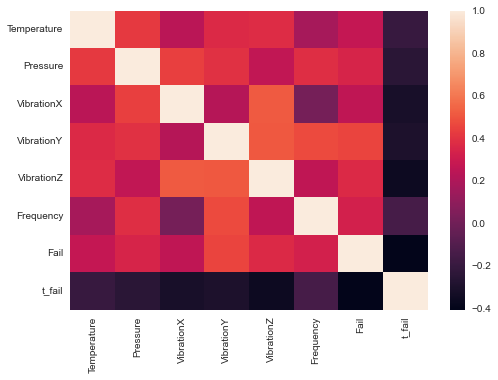

In [45]:
sns.heatmap(df[parameter + ['Fail', 't_fail']].corr())

In [46]:
# Since the highest correlations are colored orange, it can be seen that the highest correlations are 
# linked to vibrations in their three dimensions. In this case pressure is more correlated with vibrations 
# in the X direction and this direction is more inversely correlated with temperature. Also noteworthy is a
# linear correlation between temperature and pressure. An interesting point is that the parameters are more
# inversely proportional to the cycles closest to the failures (t_fail).

In [47]:
# Through the analysis of the correlation matrix, it is concluded that all parameters can be treated as 
# independent variables in a machine learning model, for example.

# 2 - Modeling

## 2.1 - Insights and Exploration

In [48]:
# This topic can be considered a draft for exploring new variables and modeling proposals

### 2.1.1 - Discussion of Types of Learning

In [49]:
# When thinking about modeling the behavior of the failure phenomenon, the first approach that emerged 
# was the construction of a predictive model. Thus, a supervised approach would be employed to determine 
# the moment of equipment failure. With this approach, we could determine the timing and proximity of the 
# failure through of regression and classification tasks. With regression we would try to generate a 
# curve to describe the variable t_fail, which measures the amount of Cycles remaining for a failure to 
# occur, here a failure would occur in t_fail = 0. With the classification we could determine the time of 
# failure by the Fail feature, as well as predict periods that occur before a failure - approach used in 
# this case. With these predictive approaches, it would be possible to easily track performance metrics 
# and information gains for each feature. As a basis in the descriptive e-mail of this case, this approach
# will be employed by generating inputs sufficient to obtain the required information.
# A convenient approach, which will not be discussed here, is the use of anomalies detection. With these 
# methods, it would be possible to analyze and find anomalies in the Cycles vs. Variables (Setups + 
# Parameters) curves. Here temporal analysis techniques and unsupervised approaches, could also be used.

### 2.1.2 Regressive Approach - Random Sampling to Predict t_fail

In [50]:
# Through data analysis, a regressive approach is initially proposed, aiming to predict the moment
# of equipment failure. Previously, the t_fail variable was created to express the cycles that precede a 
# failure, it will be used here as a target. Setups configurations will be considered as 
# categorical variables and parameters as numeric variables. An autoML library will be used to save time 
# in choosing the model and creating a modeling pipline. In this step, combinations of numerical variables 
# will be tested, since physically they can represent other notions about the state of the equipment. 
# In this perspective, the objective is to find thermodynamic relationships mainly in the combination of 
# pressure and temperature. Combinations can be done using a polynomial approach, for example. 
# As some tested models may suffer from the scaling of variables, a technique will be used to circumvent 
# this.

#### 2.1.2.1 - Random Sampling to Predict t_fail: Using all variables.

In [51]:
# Here we instantiate the modeling environment, mainly with regard to data treatment. We will initially 
# choose a random train (80% of the data) and test set on df. And we will also create a validation set 
# on the training data to evaluate the performance of the model in the cross-validation process, will be 
# chosen 10 folds here. The categorical_features parameter performs a treatment on the categorical data 
# making a dummyzation (like a OneHotEncoder). With the normalize parameter, we perform a zscore 
# normalization. As discussed in the conclusion of the data analysis, we didn't worry about outliers,
# missing values and multicollinearity.

from pycaret.regression import *
env_model = setup(data = df[parameter + setups + ['t_fail']],  target = 't_fail', train_size = .8,
                 fold = 10, categorical_features = setups, normalize = True,
                 normalize_method = 'zscore', fold_strategy = 'kfold', session_id = 4321, silent = True)

In [52]:
# Training columns
get_config('X_train').columns

Index(['Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ',
       'Frequency', 'Preset_1_1', 'Preset_1_2', 'Preset_1_3', 'Preset_2_1',
       'Preset_2_2', 'Preset_2_3', 'Preset_2_4', 'Preset_2_5', 'Preset_2_6',
       'Preset_2_7', 'Preset_2_8'],
      dtype='object')

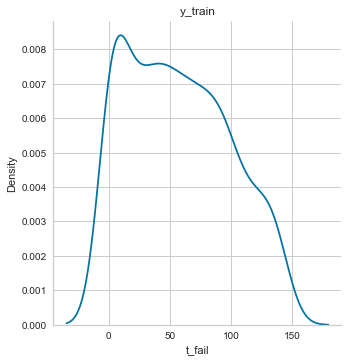

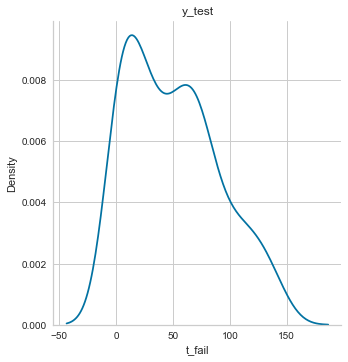

In [53]:
# Observing the distribution of the target in the training and test data
# It would be interesting to explore the distribution for all variables.

for i in ['y_train', 'y_test']:
    
     sns.displot(x= get_config(i), kind="kde").set(title=i)

In [54]:
# Here we will compare the models available in Pycaret for the regression task. This function imports
# setup() function settings.
compare_models(cross_validation = True)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=4321,
      selection='cyclic', tol=0.0001, warm_start=False)

In [55]:
def plot_test_validation_prediction(df_prediction_pycaret):
    
    df_prediction_pycaret
    fig, ax = plt.subplots()
    ax.scatter(df_prediction_pycaret.t_fail, df_prediction_pycaret.Label, edgecolors=(0, 0, 0))
    ax.plot([-1, df_prediction_pycaret.t_fail.max()], 
            [-1, df_prediction_pycaret.t_fail.max()], 'k--', lw=4)

    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title('Actual vs. Predicted')

    plt.show()

In [56]:
# The Lasso regressive model performed better for R2. It and a tree-based model will be optimized in relation 
# to R2 in their respective hyperparameter spaces. The idea of using a tree-based model is to use inputs 
# for feature selection.
lasso_tuned = tune_model(create_model('lasso'), optimize = 'R2')

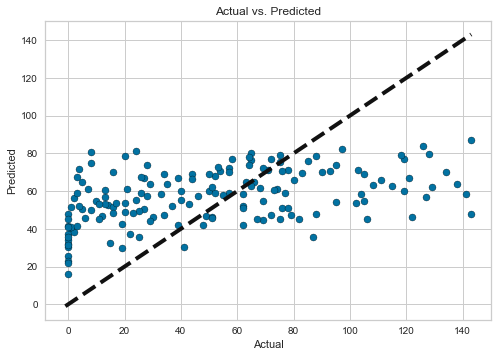

In [57]:
plot_test_validation_prediction(predict_model(lasso_tuned))

In [58]:
rf_tuned = tune_model(create_model('rf'), optimize = 'R2')

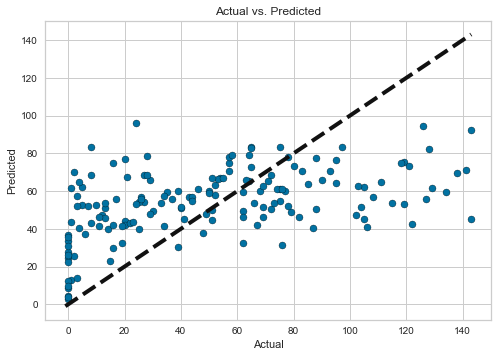

In [59]:
plot_test_validation_prediction(predict_model(rf_tuned))

In [60]:
lasso_tuned , rf_tuned

(Lasso(alpha=2.08, copy_X=True, fit_intercept=True, max_iter=1000,
       normalize=False, positive=False, precompute=False, random_state=4321,
       selection='cyclic', tol=0.0001, warm_start=False),
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                       max_depth=8, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.001,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=210, n_jobs=-1, oob_score=False,
                       random_state=4321, verbose=0, warm_start=False))

In [61]:
# The importance of features for the regressive Lasso model. This model is interesting because it presents 
# an explicit mathematical function. The importance values here are the coefficients of the variables in 
# the model.
pd.DataFrame({'Feature': get_config('X_train').columns, 
              'Value' : abs(lasso_tuned.coef_)}).sort_values(by='Value', ascending=False).head(6)

Feature     Value
4    VibrationZ  7.400089
3    VibrationY  4.935721
2    VibrationX  4.362062
1      Pressure  1.930495
0   Temperature  0.000000
11   Preset_2_3  0.000000

In [62]:
# The importance of the features for the Random Forest Regressive model.

feature_importances = pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(rf_tuned.feature_importances_)}).sort_values(by='Value', ascending=False)
feature_importances['Value_Cum'] = feature_importances.Value.cumsum()

feature2use = feature_importances.query("Value_Cum < .95")
feature_importances.head(10)

Feature     Value  Value_Cum
4    VibrationZ  0.194282   0.194282
2    VibrationX  0.185104   0.379385
3    VibrationY  0.175772   0.555157
1      Pressure  0.122846   0.678003
5     Frequency  0.117551   0.795553
0   Temperature  0.102713   0.898267
13   Preset_2_5  0.015793   0.914060
6    Preset_1_1  0.012713   0.926773
7    Preset_1_2  0.011603   0.938376
15   Preset_2_7  0.011040   0.949417

#### 2.1.2.2 - Random Sampling to Predict t_fail: Using numeric data and its relationships (polynomial, relationship, and iterative)

In [63]:
# Both models show great information gain based on Parameters (Pressure, Temp., Vibrations and Frequency)
# values. This way, a model without the categorical variables will now be tested. It is used here to test 
# the polynomial construction of new variables from numerical ones too.
# With polynomial_features we get second order relationships and with feature_ratio we get 
# variable x / variable y relationships.

env_model = setup(data = df[parameter + ['t_fail']],  target = 't_fail', train_size = .8,
                 fold = 10, categorical_features = [], normalize = True, polynomial_features = True,
                  polynomial_degree = 2, feature_ratio = True, feature_interaction = True, normalize_method = 'zscore', 
                  fold_strategy = 'kfold', session_id = 4321, silent = True, verbose=False)

In [64]:
best_model = compare_models(cross_validation = True)

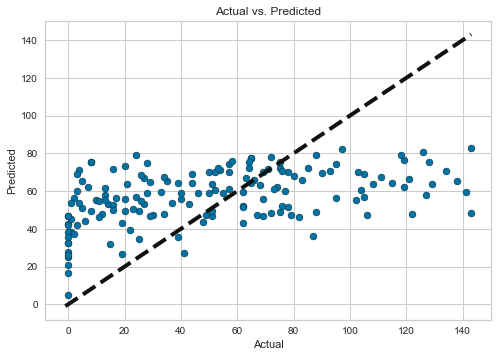

In [65]:
best_model = tune_model(best_model, optimize="R2")  
    
plot_test_validation_prediction(predict_model(best_model))

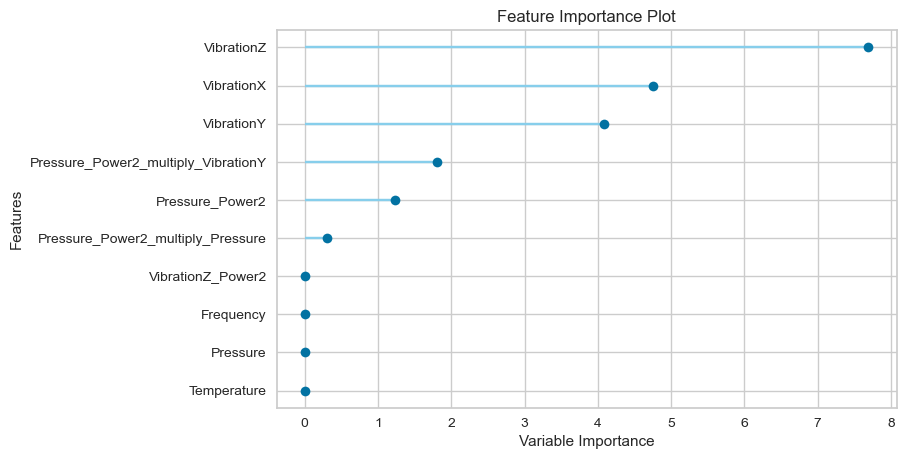

In [66]:
plot_model(best_model, plot = 'feature')

#### 2.1.2.3 - Random Sampling to Predict t_fail: Using numeric and categorical data and its relationships (polynomial, relationship, and iterative) with the feature_selection tecnique

In [67]:
# Building and finalizing the final models of this step

In [68]:
# The feature_selection was used here to select features using a combination of various permutation 
# importance techniques including Random Forest, Adaboost and Linear correlation with target variable.

env_model = setup(data = df[parameter + setups + ['t_fail']],  target = 't_fail', train_size = .8,
                 fold = 10, categorical_features = setups, normalize = True, polynomial_features = True,
                  polynomial_degree = 2, feature_ratio = True, feature_interaction = True, normalize_method = 'zscore', 
                  fold_strategy = 'kfold', session_id = 4321, silent = True, verbose=False, feature_selection = True)

In [69]:
get_config('X_train').columns

Index(['Preset_2_3', 'Pressure_Power2', 'VibrationZ', 'Preset_2_1',
       'Temperature', 'VibrationX', 'Preset_2_6', 'Preset_2_2', 'Preset_1_3',
       'VibrationZ_Power2', 'VibrationY', 'Preset_1_1', 'Preset_1_2',
       'Preset_2_4', 'Preset_2_8', 'Pressure', 'Frequency', 'Preset_2_7',
       'Preset_2_5', 'VibrationY_multiply_VibrationZ',
       'Frequency_divide_Pressure', 'VibrationY_multiply_Pressure',
       'Temperature_divide_VibrationZ_Power2', 'Frequency_multiply_VibrationX',
       'Preset_1_1_multiply_Temperature', 'VibrationX_divide_VibrationY',
       'Preset_1_2_multiply_VibrationZ',
       'Preset_1_2_multiply_VibrationZ_Power2', 'VibrationY_divide_VibrationZ',
       'Preset_2_8_multiply_VibrationY'],
      dtype='object')

In [70]:
compare_models()

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=4321, verbose=0, warm_start=False)

In [71]:
lasso_tuned = tune_model(create_model('lasso'), optimize = 'R2', choose_better=True)

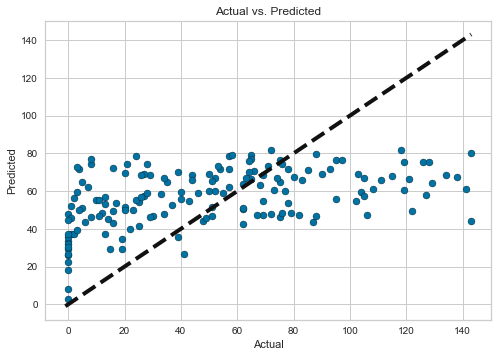

In [72]:
# Predicted vs. Real

plot_test_validation_prediction(predict_model(lasso_tuned))

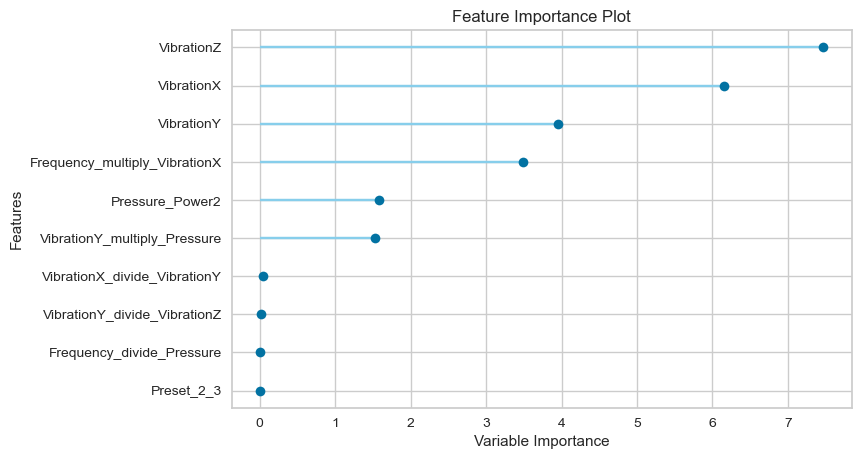

In [73]:
plot_model(lasso_tuned, plot = 'feature')

In [74]:
rf_tuned = tune_model(create_model('rf'), optimize = 'R2', choose_better=True)

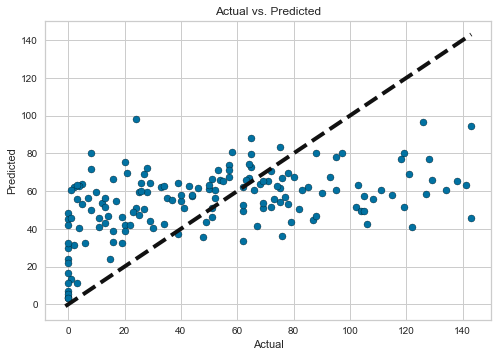

In [75]:
# Predicted vs. Real

plot_test_validation_prediction(predict_model(rf_tuned))

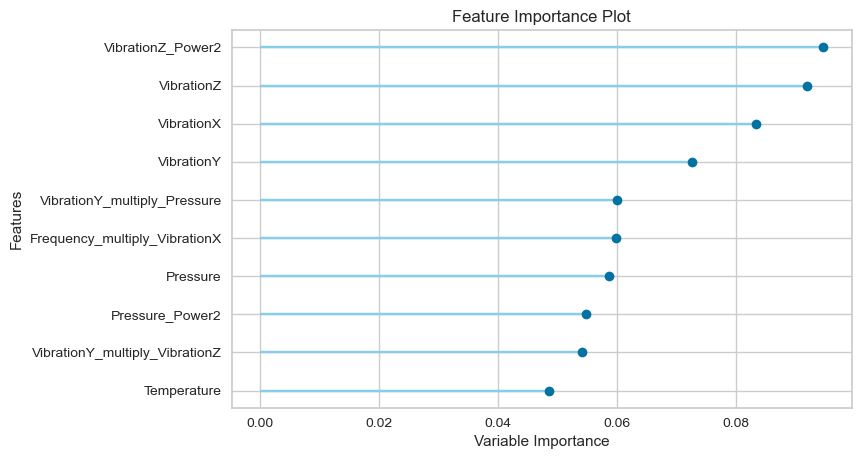

In [76]:
plot_model(rf_tuned, plot = 'feature')

#### 2.1.2.4 - To Analyze Later

In [77]:
# In the regressive approach, a time series training setup can still be tested.

### 2.1.3 Classification Approach - Predicting target that indicates a period before failure

In [78]:
# Although the regressive approach has given several positive insights to the understanding of the problem,
# a supervised classification approach will be considered, aiming at more satisfactory performances in 
# identifying the occurrence of the failure. We saw with the regressive approach and with the analysis of 
# the graphs Parameters (Vibrations, Temperature and Pressure) vs. t_fail the relevance of variables 
# linked to vibrations. In this way, we will propose a classification approach seeking to predict a 
# failure with 5 cycles before it happens. This last number was chosen by looking at the charts mentioned 
# here. It can be seen that in these 5 cycles before failure, the vibration variables usually have values 
# higher and above their averages.

In [79]:
# Same as previous considerations used in the regressive approach to prepare setup(),
# can be used here.

In [80]:
# Creation of new target
last_cycles = 5

df['target_last_5'] = np.where(df.t_fail <= last_cycles, 1, 0 )
df.target_last_5.value_counts()

0    689
1    111
Name: target_last_5, dtype: int64

#### 2.1.3.1 - Using numeric and categorical data and its relationships (polynomial, relationship, and iterative) with the feature_selection tecnique

In [81]:
from pycaret.classification import *

env_model = setup(data = df[parameter + setups + ['target_last_5']],  target = 'target_last_5', train_size = .8,
                 fold = 10, categorical_features = setups, normalize = True, polynomial_features = True,
                  polynomial_degree = 2, feature_ratio = True, feature_interaction = True, normalize_method = 'zscore', 
                  fold_strategy = 'kfold', session_id = 421, silent = True, verbose=False, feature_selection = True)

In [82]:
for i in ['y_train', 'y_test']:
    
     print(i, get_config(i).value_counts()/get_config(i).value_counts().sum())

y_train 0    0.860938
1    0.139063
Name: target_last_5, dtype: float64
y_test 0    0.8625
1    0.1375
Name: target_last_5, dtype: float64


In [83]:
# Here I will take the first 4 models to work with
best_models = compare_models(n_select=4)

In [84]:
# Here the models will be tuned looking for the best hyperparameters that optimize the F1 metric, 
# as it seeks to accurately indicate the moment that covers the failure period (Precision) and also
# the maximum number of these moments (Recall)

tuned_models = [tune_model(i, optimize='F1', choose_better=True) for i in best_models]

In [85]:
# Observing the prediction on the test set (20% of the data)

predict_model(tuned_models[0])

VibrationY_Power2  Preset_2_3  VibrationZ  Temperature  VibrationX  \
0            -0.482710         0.0   -0.424039     0.177280   -0.420720   
1             1.851740         0.0    0.651170     0.890472    0.524851   
2            -0.765128         0.0   -0.234809     1.122795    1.805523   
3             2.088704         0.0    0.177595     0.457094   -0.161978   
4             0.158118         0.0   -0.580010    -0.522593   -0.565020   
..                 ...         ...         ...          ...         ...   
155          -0.421189         0.0    0.252521    -0.989456   -1.109801   
156           0.355189         1.0   -1.010167     0.291099   -0.898553   
157          -0.669016         0.0   -0.249723    -1.034573   -0.255226   
158           1.132331         0.0    0.093117    -0.481244    0.963527   
159           1.417449         0.0    0.613906     2.042939    0.810469   

     Preset_2_6  Preset_2_2  Temperature_Power2  Preset_1_3  \
0           0.0         1.0           -0.002983         0.0   
1           0.0         0.0            0.601047         0.0   
2           0.0         0.0            0.826862         0.0   
3           0.0         0.0            0.217965         0.0   
4           0.0         1.0           -0.464941         1.0   
..          ...         ...                 ...         ...   
155         0.0         0.0           -0.701061         1.0   
156         0.0         0.0            0.084393         0.0   
157         0.0         0.0           -0.720825         0.0   
158         0.0         0.0           -0.441249         0.0   
159         1.0         0.0            1.861471         1.0   

     VibrationZ_Power2  ...  Pressure_divide_VibrationX  \
0            -0.479826  ...                   -2.638580   
1             0.441867  ...                   -0.427347   
2            -0.344557  ...                    0.204353   
3            -0.009880  ...                   -0.159092   
4            -0.582668  ...                    1.279953   
..                 ...  ...                         ...   
155           0.056793  ...                    1.141379   
156          -0.825781  ...                    0.491647   
157          -0.355635  ...                    3.752094   
158          -0.082888  ...                    0.194115   
159           0.403708  ...                    3.483332   

     Frequency_multiply_VibrationY_Power2  Frequency_multiply_VibrationX  \
0                               -0.363543                      -0.316857   
1                                2.508661                       0.711047   
2                                0.374894                      -0.884663   
3                                1.504337                      -0.116660   
4                               -0.202989                       0.725360   
..                                    ...                            ...   
155                              0.374406                       0.986532   
156                              0.260838                      -0.659866   
157                              0.614923                       0.234590   
158                             -0.605458                      -0.515198   
159                              1.245084                       0.711915   

     Frequency_multiply_Temperature  VibrationZ_Power2_multiply_VibrationZ  \
0                          0.133515                               0.203465   
1                          1.206375                               0.287731   
2                         -0.550143                               0.080905   
3                          0.329210                              -0.001755   
4                          0.670894                               0.337954   
..                              ...                                    ...   
155                        0.879554                               0.014341   
156                        0.213773                               0.834176   
157                    

In [86]:
predict_model(tuned_models[1])

VibrationY_Power2  Preset_2_3  VibrationZ  Temperature  VibrationX  \
0            -0.482710         0.0   -0.424039     0.177280   -0.420720   
1             1.851740         0.0    0.651170     0.890472    0.524851   
2            -0.765128         0.0   -0.234809     1.122795    1.805523   
3             2.088704         0.0    0.177595     0.457094   -0.161978   
4             0.158118         0.0   -0.580010    -0.522593   -0.565020   
..                 ...         ...         ...          ...         ...   
155          -0.421189         0.0    0.252521    -0.989456   -1.109801   
156           0.355189         1.0   -1.010167     0.291099   -0.898553   
157          -0.669016         0.0   -0.249723    -1.034573   -0.255226   
158           1.132331         0.0    0.093117    -0.481244    0.963527   
159           1.417449         0.0    0.613906     2.042939    0.810469   

     Preset_2_6  Preset_2_2  Temperature_Power2  Preset_1_3  \
0           0.0         1.0           -0.002983         0.0   
1           0.0         0.0            0.601047         0.0   
2           0.0         0.0            0.826862         0.0   
3           0.0         0.0            0.217965         0.0   
4           0.0         1.0           -0.464941         1.0   
..          ...         ...                 ...         ...   
155         0.0         0.0           -0.701061         1.0   
156         0.0         0.0            0.084393         0.0   
157         0.0         0.0           -0.720825         0.0   
158         0.0         0.0           -0.441249         0.0   
159         1.0         0.0            1.861471         1.0   

     VibrationZ_Power2  ...  Pressure_divide_VibrationX  \
0            -0.479826  ...                   -2.638580   
1             0.441867  ...                   -0.427347   
2            -0.344557  ...                    0.204353   
3            -0.009880  ...                   -0.159092   
4            -0.582668  ...                    1.279953   
..                 ...  ...                         ...   
155           0.056793  ...                    1.141379   
156          -0.825781  ...                    0.491647   
157          -0.355635  ...                    3.752094   
158          -0.082888  ...                    0.194115   
159           0.403708  ...                    3.483332   

     Frequency_multiply_VibrationY_Power2  Frequency_multiply_VibrationX  \
0                               -0.363543                      -0.316857   
1                                2.508661                       0.711047   
2                                0.374894                      -0.884663   
3                                1.504337                      -0.116660   
4                               -0.202989                       0.725360   
..                                    ...                            ...   
155                              0.374406                       0.986532   
156                              0.260838                      -0.659866   
157                              0.614923                       0.234590   
158                             -0.605458                      -0.515198   
159                              1.245084                       0.711915   

     Frequency_multiply_Temperature  VibrationZ_Power2_multiply_VibrationZ  \
0                          0.133515                               0.203465   
1                          1.206375                               0.287731   
2                         -0.550143                               0.080905   
3                          0.329210                              -0.001755   
4                          0.670894                               0.337954   
..                              ...                                    ...   
155                        0.879554                               0.014341   
156                        0.213773                               0.834176   
157                    

In [87]:
predict_model(tuned_models[2])

VibrationY_Power2  Preset_2_3  VibrationZ  Temperature  VibrationX  \
0            -0.482710         0.0   -0.424039     0.177280   -0.420720   
1             1.851740         0.0    0.651170     0.890472    0.524851   
2            -0.765128         0.0   -0.234809     1.122795    1.805523   
3             2.088704         0.0    0.177595     0.457094   -0.161978   
4             0.158118         0.0   -0.580010    -0.522593   -0.565020   
..                 ...         ...         ...          ...         ...   
155          -0.421189         0.0    0.252521    -0.989456   -1.109801   
156           0.355189         1.0   -1.010167     0.291099   -0.898553   
157          -0.669016         0.0   -0.249723    -1.034573   -0.255226   
158           1.132331         0.0    0.093117    -0.481244    0.963527   
159           1.417449         0.0    0.613906     2.042939    0.810469   

     Preset_2_6  Preset_2_2  Temperature_Power2  Preset_1_3  \
0           0.0         1.0           -0.002983         0.0   
1           0.0         0.0            0.601047         0.0   
2           0.0         0.0            0.826862         0.0   
3           0.0         0.0            0.217965         0.0   
4           0.0         1.0           -0.464941         1.0   
..          ...         ...                 ...         ...   
155         0.0         0.0           -0.701061         1.0   
156         0.0         0.0            0.084393         0.0   
157         0.0         0.0           -0.720825         0.0   
158         0.0         0.0           -0.441249         0.0   
159         1.0         0.0            1.861471         1.0   

     VibrationZ_Power2  ...  Pressure_divide_VibrationX  \
0            -0.479826  ...                   -2.638580   
1             0.441867  ...                   -0.427347   
2            -0.344557  ...                    0.204353   
3            -0.009880  ...                   -0.159092   
4            -0.582668  ...                    1.279953   
..                 ...  ...                         ...   
155           0.056793  ...                    1.141379   
156          -0.825781  ...                    0.491647   
157          -0.355635  ...                    3.752094   
158          -0.082888  ...                    0.194115   
159           0.403708  ...                    3.483332   

     Frequency_multiply_VibrationY_Power2  Frequency_multiply_VibrationX  \
0                               -0.363543                      -0.316857   
1                                2.508661                       0.711047   
2                                0.374894                      -0.884663   
3                                1.504337                      -0.116660   
4                               -0.202989                       0.725360   
..                                    ...                            ...   
155                              0.374406                       0.986532   
156                              0.260838                      -0.659866   
157                              0.614923                       0.234590   
158                             -0.605458                      -0.515198   
159                              1.245084                       0.711915   

     Frequency_multiply_Temperature  VibrationZ_Power2_multiply_VibrationZ  \
0                          0.133515                               0.203465   
1                          1.206375                               0.287731   
2                         -0.550143                               0.080905   
3                          0.329210                              -0.001755   
4                          0.670894                               0.337954   
..                              ...                                    ...   
155                        0.879554                               0.014341   
156                        0.213773                               0.834176   
157                    

In [88]:
predict_model(tuned_models[3])

VibrationY_Power2  Preset_2_3  VibrationZ  Temperature  VibrationX  \
0            -0.482710         0.0   -0.424039     0.177280   -0.420720   
1             1.851740         0.0    0.651170     0.890472    0.524851   
2            -0.765128         0.0   -0.234809     1.122795    1.805523   
3             2.088704         0.0    0.177595     0.457094   -0.161978   
4             0.158118         0.0   -0.580010    -0.522593   -0.565020   
..                 ...         ...         ...          ...         ...   
155          -0.421189         0.0    0.252521    -0.989456   -1.109801   
156           0.355189         1.0   -1.010167     0.291099   -0.898553   
157          -0.669016         0.0   -0.249723    -1.034573   -0.255226   
158           1.132331         0.0    0.093117    -0.481244    0.963527   
159           1.417449         0.0    0.613906     2.042939    0.810469   

     Preset_2_6  Preset_2_2  Temperature_Power2  Preset_1_3  \
0           0.0         1.0           -0.002983         0.0   
1           0.0         0.0            0.601047         0.0   
2           0.0         0.0            0.826862         0.0   
3           0.0         0.0            0.217965         0.0   
4           0.0         1.0           -0.464941         1.0   
..          ...         ...                 ...         ...   
155         0.0         0.0           -0.701061         1.0   
156         0.0         0.0            0.084393         0.0   
157         0.0         0.0           -0.720825         0.0   
158         0.0         0.0           -0.441249         0.0   
159         1.0         0.0            1.861471         1.0   

     VibrationZ_Power2  ...  Pressure_divide_VibrationX  \
0            -0.479826  ...                   -2.638580   
1             0.441867  ...                   -0.427347   
2            -0.344557  ...                    0.204353   
3            -0.009880  ...                   -0.159092   
4            -0.582668  ...                    1.279953   
..                 ...  ...                         ...   
155           0.056793  ...                    1.141379   
156          -0.825781  ...                    0.491647   
157          -0.355635  ...                    3.752094   
158          -0.082888  ...                    0.194115   
159           0.403708  ...                    3.483332   

     Frequency_multiply_VibrationY_Power2  Frequency_multiply_VibrationX  \
0                               -0.363543                      -0.316857   
1                                2.508661                       0.711047   
2                                0.374894                      -0.884663   
3                                1.504337                      -0.116660   
4                               -0.202989                       0.725360   
..                                    ...                            ...   
155                              0.374406                       0.986532   
156                              0.260838                      -0.659866   
157                              0.614923                       0.234590   
158                             -0.605458                      -0.515198   
159                              1.245084                       0.711915   

     Frequency_multiply_Temperature  VibrationZ_Power2_multiply_VibrationZ  \
0                          0.133515                               0.203465   
1                          1.206375                               0.287731   
2                         -0.550143                               0.080905   
3                          0.329210                              -0.001755   
4                          0.670894                               0.337954   
..                              ...                                    ...   
155                        0.879554                               0.014341   
156                        0.213773                               0.834176   
157                    

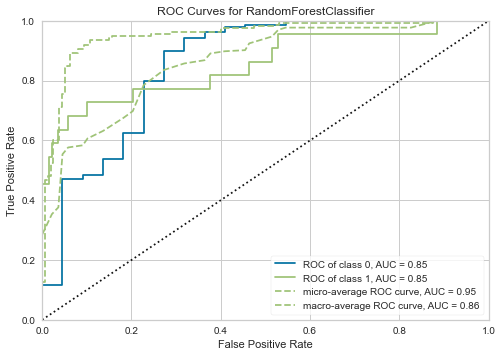

In [89]:
# The Random Forest Model after optimization maintained the highest recall.
# In this way, it will be used as an input generator of this approach, as follows:

rf = tuned_models[0]
plot_model(rf, plot = 'auc')

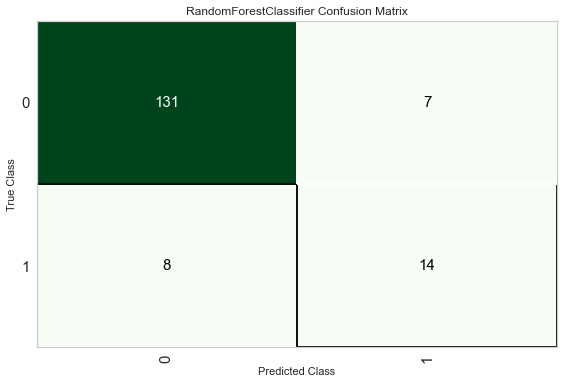

In [90]:
plot_model(rf, plot = 'confusion_matrix')

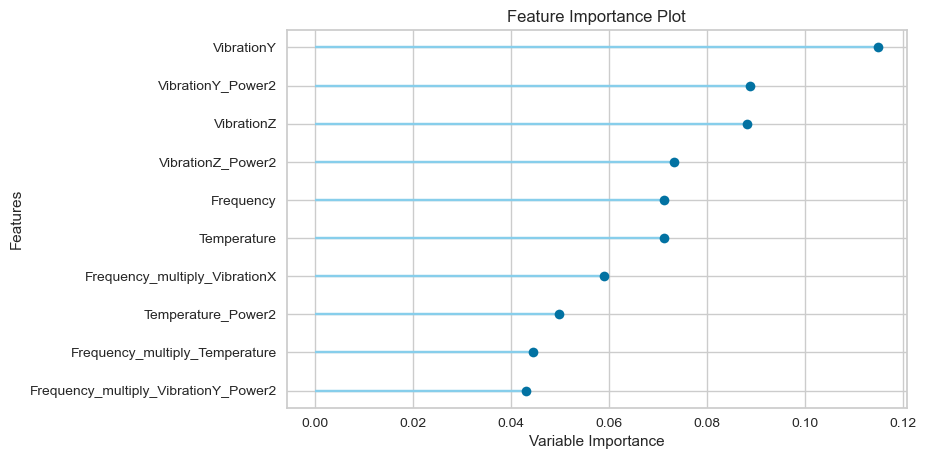

In [91]:
plot_model(rf, plot = 'feature')

#### 2.1.3.2 - Using numeric and categorical data without feature engineering

In [92]:
# Testing without the construction of polynomial and relation variables

env_model = setup(data = df[parameter + setups + ['target_last_5']],  target = 'target_last_5', 
                  train_size = .8, fold = 10, categorical_features = setups, normalize = True ,
                  fold_strategy = 'kfold', session_id = 421, silent = True, verbose=True, feature_selection = True)

best_models = compare_models(n_select=4)
tuned_models = [tune_model(i, optimize='F1', choose_better=True) for i in best_models]

In [93]:
predict_model(tuned_models[0])

VibrationZ  Pressure  Temperature  VibrationX  VibrationY  Frequency  \
0     -0.424039  1.110103     0.177280   -0.420720   -0.387460   0.753129   
1      0.651170 -0.224294     0.890472    0.524851    1.755731   1.354759   
2     -0.234809  0.368964     1.122795    1.805523   -0.864511  -0.489976   
3      0.177595  0.025769     0.457094   -0.161978    1.911075   0.720225   
4     -0.580010 -0.723199    -0.522593   -0.565020    0.385373  -1.283779   
..          ...       ...          ...         ...         ...        ...   
155    0.252521 -1.266703    -0.989456   -1.109801   -0.299476  -0.888927   
156   -1.010167 -0.441771     0.291099   -0.898553    0.579958   0.734365   
157   -0.249723 -0.957633    -1.034573   -0.255226   -0.685043  -0.919146   
158    0.093117  0.187035    -0.481244    0.963527    1.241248  -0.534700   
159    0.613906  2.823134     2.042939    0.810469    1.453859   0.878398   

     Preset_1_1  Preset_2_6  Preset_2_2  Preset_1_2  Preset_2_7  Preset_2_4  \
0           1.0         0.0         1.0         0.0         0.0         0.0   
1           0.0         0.0         0.0         1.0         1.0         0.0   
2           1.0         0.0         0.0         0.0         0.0         0.0   
3           1.0         0.0         0.0         0.0         0.0         0.0   
4           0.0         0.0         1.0         0.0         0.0         0.0   
..          ...         ...         ...         ...         ...         ...   
155         0.0         0.0         0.0         0.0         1.0         0.0   
156         1.0         0.0         0.0         0.0         0.0         0.0   
157         1.0         0.0         0.0         0.0         0.0         0.0   
158         1.0         0.0         0.0         0.0         0.0         1.0   
159         0.0         1.0         0.0         0.0         0.0         0.0   

     Preset_2_5  Preset_1_3  Preset_2_3  target_last_5  Label   Score  
0           0.0         0.0         0.0              0      0  0.8841  
1           0.0         0.0         0.0              0      1  0.8158  
2           0.0         0.0         0.0              0      0  0.8114  
3           1.0         0.0         0.0              0      1  0.7480  
4           0.0         1.0         0.0              0      0  0.9263  
..          ...         ...         ...            ...    ...     ...  
155         0.0         1.0         0.0              0      0  0.8004  
156         0.0         0.0         1.0              0      0  0.7844  
157         0.0         0.0         0.0              1      0  0.9058  
158         0.0         0.0         0.0              0      0  0.7215  
159         0.0         1.0         0.0              1      1  0.8349  

[160 rows x 18 columns]

In [94]:
predict_model(tuned_models[1])

VibrationZ  Pressure  Temperature  VibrationX  VibrationY  Frequency  \
0     -0.424039  1.110103     0.177280   -0.420720   -0.387460   0.753129   
1      0.651170 -0.224294     0.890472    0.524851    1.755731   1.354759   
2     -0.234809  0.368964     1.122795    1.805523   -0.864511  -0.489976   
3      0.177595  0.025769     0.457094   -0.161978    1.911075   0.720225   
4     -0.580010 -0.723199    -0.522593   -0.565020    0.385373  -1.283779   
..          ...       ...          ...         ...         ...        ...   
155    0.252521 -1.266703    -0.989456   -1.109801   -0.299476  -0.888927   
156   -1.010167 -0.441771     0.291099   -0.898553    0.579958   0.734365   
157   -0.249723 -0.957633    -1.034573   -0.255226   -0.685043  -0.919146   
158    0.093117  0.187035    -0.481244    0.963527    1.241248  -0.534700   
159    0.613906  2.823134     2.042939    0.810469    1.453859   0.878398   

     Preset_1_1  Preset_2_6  Preset_2_2  Preset_1_2  Preset_2_7  Preset_2_4  \
0           1.0         0.0         1.0         0.0         0.0         0.0   
1           0.0         0.0         0.0         1.0         1.0         0.0   
2           1.0         0.0         0.0         0.0         0.0         0.0   
3           1.0         0.0         0.0         0.0         0.0         0.0   
4           0.0         0.0         1.0         0.0         0.0         0.0   
..          ...         ...         ...         ...         ...         ...   
155         0.0         0.0         0.0         0.0         1.0         0.0   
156         1.0         0.0         0.0         0.0         0.0         0.0   
157         1.0         0.0         0.0         0.0         0.0         0.0   
158         1.0         0.0         0.0         0.0         0.0         1.0   
159         0.0         1.0         0.0         0.0         0.0         0.0   

     Preset_2_5  Preset_1_3  Preset_2_3  target_last_5  Label   Score  
0           0.0         0.0         0.0              0      0  0.9052  
1           0.0         0.0         0.0              0      0  0.5719  
2           0.0         0.0         0.0              0      0  0.9044  
3           1.0         0.0         0.0              0      0  0.6591  
4           0.0         1.0         0.0              0      0  0.9961  
..          ...         ...         ...            ...    ...     ...  
155         0.0         1.0         0.0              0      0  0.9961  
156         0.0         0.0         1.0              0      0  0.9851  
157         0.0         0.0         0.0              1      0  0.9898  
158         0.0         0.0         0.0              0      0  0.9869  
159         0.0         1.0         0.0              1      0  0.5152  

[160 rows x 18 columns]

In [95]:
predict_model(tuned_models[2])

VibrationZ  Pressure  Temperature  VibrationX  VibrationY  Frequency  \
0     -0.424039  1.110103     0.177280   -0.420720   -0.387460   0.753129   
1      0.651170 -0.224294     0.890472    0.524851    1.755731   1.354759   
2     -0.234809  0.368964     1.122795    1.805523   -0.864511  -0.489976   
3      0.177595  0.025769     0.457094   -0.161978    1.911075   0.720225   
4     -0.580010 -0.723199    -0.522593   -0.565020    0.385373  -1.283779   
..          ...       ...          ...         ...         ...        ...   
155    0.252521 -1.266703    -0.989456   -1.109801   -0.299476  -0.888927   
156   -1.010167 -0.441771     0.291099   -0.898553    0.579958   0.734365   
157   -0.249723 -0.957633    -1.034573   -0.255226   -0.685043  -0.919146   
158    0.093117  0.187035    -0.481244    0.963527    1.241248  -0.534700   
159    0.613906  2.823134     2.042939    0.810469    1.453859   0.878398   

     Preset_1_1  Preset_2_6  Preset_2_2  Preset_1_2  Preset_2_7  Preset_2_4  \
0           1.0         0.0         1.0         0.0         0.0         0.0   
1           0.0         0.0         0.0         1.0         1.0         0.0   
2           1.0         0.0         0.0         0.0         0.0         0.0   
3           1.0         0.0         0.0         0.0         0.0         0.0   
4           0.0         0.0         1.0         0.0         0.0         0.0   
..          ...         ...         ...         ...         ...         ...   
155         0.0         0.0         0.0         0.0         1.0         0.0   
156         1.0         0.0         0.0         0.0         0.0         0.0   
157         1.0         0.0         0.0         0.0         0.0         0.0   
158         1.0         0.0         0.0         0.0         0.0         1.0   
159         0.0         1.0         0.0         0.0         0.0         0.0   

     Preset_2_5  Preset_1_3  Preset_2_3  target_last_5  Label   Score  
0           0.0         0.0         0.0              0      0  0.9989  
1           0.0         0.0         0.0              0      1  0.9933  
2           0.0         0.0         0.0              0      0  0.8698  
3           1.0         0.0         0.0              0      1  0.8144  
4           0.0         1.0         0.0              0      0  1.0000  
..          ...         ...         ...            ...    ...     ...  
155         0.0         1.0         0.0              0      0  0.9987  
156         0.0         0.0         1.0              0      0  0.9998  
157         0.0         0.0         0.0              1      0  0.9992  
158         0.0         0.0         0.0              0      0  0.9948  
159         0.0         1.0         0.0              1      1  0.6155  

[160 rows x 18 columns]

In [96]:
predict_model(tuned_models[3])

VibrationZ  Pressure  Temperature  VibrationX  VibrationY  Frequency  \
0     -0.424039  1.110103     0.177280   -0.420720   -0.387460   0.753129   
1      0.651170 -0.224294     0.890472    0.524851    1.755731   1.354759   
2     -0.234809  0.368964     1.122795    1.805523   -0.864511  -0.489976   
3      0.177595  0.025769     0.457094   -0.161978    1.911075   0.720225   
4     -0.580010 -0.723199    -0.522593   -0.565020    0.385373  -1.283779   
..          ...       ...          ...         ...         ...        ...   
155    0.252521 -1.266703    -0.989456   -1.109801   -0.299476  -0.888927   
156   -1.010167 -0.441771     0.291099   -0.898553    0.579958   0.734365   
157   -0.249723 -0.957633    -1.034573   -0.255226   -0.685043  -0.919146   
158    0.093117  0.187035    -0.481244    0.963527    1.241248  -0.534700   
159    0.613906  2.823134     2.042939    0.810469    1.453859   0.878398   

     Preset_1_1  Preset_2_6  Preset_2_2  Preset_1_2  Preset_2_7  Preset_2_4  \
0           1.0         0.0         1.0         0.0         0.0         0.0   
1           0.0         0.0         0.0         1.0         1.0         0.0   
2           1.0         0.0         0.0         0.0         0.0         0.0   
3           1.0         0.0         0.0         0.0         0.0         0.0   
4           0.0         0.0         1.0         0.0         0.0         0.0   
..          ...         ...         ...         ...         ...         ...   
155         0.0         0.0         0.0         0.0         1.0         0.0   
156         1.0         0.0         0.0         0.0         0.0         0.0   
157         1.0         0.0         0.0         0.0         0.0         0.0   
158         1.0         0.0         0.0         0.0         0.0         1.0   
159         0.0         1.0         0.0         0.0         0.0         0.0   

     Preset_2_5  Preset_1_3  Preset_2_3  target_last_5  Label   Score  
0           0.0         0.0         0.0              0      0  0.5829  
1           0.0         0.0         0.0              0      1  0.6259  
2           0.0         0.0         0.0              0      0  0.5867  
3           1.0         0.0         0.0              0      1  0.6173  
4           0.0         1.0         0.0              0      0  0.7370  
..          ...         ...         ...            ...    ...     ...  
155         0.0         1.0         0.0              0      0  0.6683  
156         0.0         0.0         1.0              0      0  0.6629  
157         0.0         0.0         0.0              1      0  0.7286  
158         0.0         0.0         0.0              0      0  0.5477  
159         0.0         1.0         0.0              1      1  0.6175  

[160 rows x 18 columns]

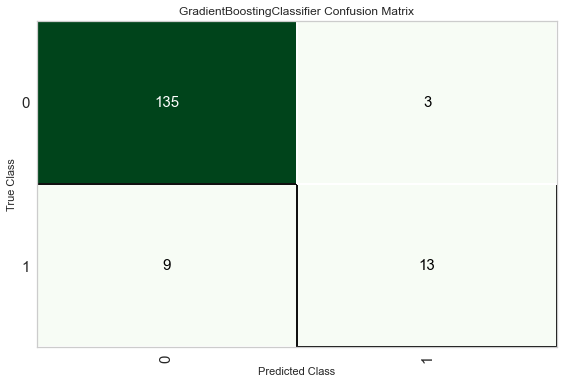

In [97]:
plot_model(tuned_models[1], plot='confusion_matrix')

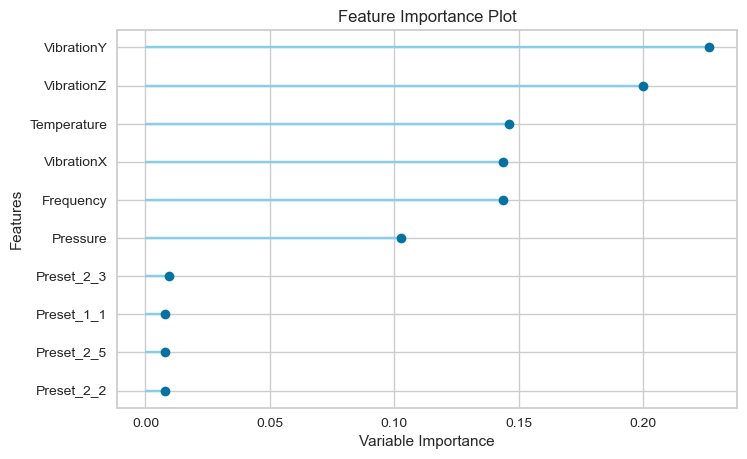

In [98]:
plot_model(tuned_models[1], plot='feature')

#### 2.1.3.3 - Using just numeric data without feature engineering

In [99]:
# Testing only with parameter variables

env_model = setup(data = df[parameter + ['target_last_5']],  target = 'target_last_5', train_size = .8,
                 fold = 10, categorical_features = [], normalize = True , fold_strategy = 'kfold', 
                  session_id = 421, silent = True, verbose=True, feature_selection = True)

best_models = compare_models(n_select=4)
tuned_models = [tune_model(i, optimize='F1', choose_better=True) for i in best_models]

In [100]:
predict_model(tuned_models[0])

VibrationZ  Temperature  Pressure  VibrationX  VibrationY  Frequency  \
0     -0.424039     0.177280  1.110103   -0.420720   -0.387460   0.753129   
1      0.651170     0.890472 -0.224294    0.524851    1.755731   1.354759   
2     -0.234809     1.122795  0.368964    1.805523   -0.864511  -0.489976   
3      0.177595     0.457094  0.025769   -0.161978    1.911075   0.720225   
4     -0.580010    -0.522593 -0.723199   -0.565020    0.385373  -1.283779   
..          ...          ...       ...         ...         ...        ...   
155    0.252521    -0.989456 -1.266703   -1.109801   -0.299476  -0.888927   
156   -1.010167     0.291099 -0.441771   -0.898553    0.579958   0.734365   
157   -0.249723    -1.034573 -0.957633   -0.255226   -0.685043  -0.919146   
158    0.093117    -0.481244  0.187035    0.963527    1.241248  -0.534700   
159    0.613906     2.042939  2.823134    0.810469    1.453859   0.878398   

     target_last_5  Label   Score  
0                0      0  0.9999  
1                0      1  0.9752  
2                0      0  0.9625  
3                0      1  0.7649  
4                0      0  0.9999  
..             ...    ...     ...  
155              0      0  0.9998  
156              0      0  0.9998  
157              1      0  0.9996  
158              0      0  0.9996  
159              1      0  0.6969  

[160 rows x 9 columns]

In [101]:
predict_model(tuned_models[1])

VibrationZ  Temperature  Pressure  VibrationX  VibrationY  Frequency  \
0     -0.424039     0.177280  1.110103   -0.420720   -0.387460   0.753129   
1      0.651170     0.890472 -0.224294    0.524851    1.755731   1.354759   
2     -0.234809     1.122795  0.368964    1.805523   -0.864511  -0.489976   
3      0.177595     0.457094  0.025769   -0.161978    1.911075   0.720225   
4     -0.580010    -0.522593 -0.723199   -0.565020    0.385373  -1.283779   
..          ...          ...       ...         ...         ...        ...   
155    0.252521    -0.989456 -1.266703   -1.109801   -0.299476  -0.888927   
156   -1.010167     0.291099 -0.441771   -0.898553    0.579958   0.734365   
157   -0.249723    -1.034573 -0.957633   -0.255226   -0.685043  -0.919146   
158    0.093117    -0.481244  0.187035    0.963527    1.241248  -0.534700   
159    0.613906     2.042939  2.823134    0.810469    1.453859   0.878398   

     target_last_5  Label   Score  
0                0      0  0.9999  
1                0      1  0.9859  
2                0      0  0.9164  
3                0      1  0.7894  
4                0      0  1.0000  
..             ...    ...     ...  
155              0      0  0.9998  
156              0      0  0.9998  
157              1      0  0.9997  
158              0      0  0.9902  
159              1      1  0.5346  

[160 rows x 9 columns]

In [102]:
predict_model(tuned_models[2])

VibrationZ  Temperature  Pressure  VibrationX  VibrationY  Frequency  \
0     -0.424039     0.177280  1.110103   -0.420720   -0.387460   0.753129   
1      0.651170     0.890472 -0.224294    0.524851    1.755731   1.354759   
2     -0.234809     1.122795  0.368964    1.805523   -0.864511  -0.489976   
3      0.177595     0.457094  0.025769   -0.161978    1.911075   0.720225   
4     -0.580010    -0.522593 -0.723199   -0.565020    0.385373  -1.283779   
..          ...          ...       ...         ...         ...        ...   
155    0.252521    -0.989456 -1.266703   -1.109801   -0.299476  -0.888927   
156   -1.010167     0.291099 -0.441771   -0.898553    0.579958   0.734365   
157   -0.249723    -1.034573 -0.957633   -0.255226   -0.685043  -0.919146   
158    0.093117    -0.481244  0.187035    0.963527    1.241248  -0.534700   
159    0.613906     2.042939  2.823134    0.810469    1.453859   0.878398   

     target_last_5  Label   Score  
0                0      0  1.0000  
1                0      1  0.6254  
2                0      0  1.0000  
3                0      0  0.6807  
4                0      0  1.0000  
..             ...    ...     ...  
155              0      0  1.0000  
156              0      0  1.0000  
157              1      0  1.0000  
158              0      0  1.0000  
159              1      1  0.5888  

[160 rows x 9 columns]

In [103]:
predict_model(tuned_models[3])

VibrationZ  Temperature  Pressure  VibrationX  VibrationY  Frequency  \
0     -0.424039     0.177280  1.110103   -0.420720   -0.387460   0.753129   
1      0.651170     0.890472 -0.224294    0.524851    1.755731   1.354759   
2     -0.234809     1.122795  0.368964    1.805523   -0.864511  -0.489976   
3      0.177595     0.457094  0.025769   -0.161978    1.911075   0.720225   
4     -0.580010    -0.522593 -0.723199   -0.565020    0.385373  -1.283779   
..          ...          ...       ...         ...         ...        ...   
155    0.252521    -0.989456 -1.266703   -1.109801   -0.299476  -0.888927   
156   -1.010167     0.291099 -0.441771   -0.898553    0.579958   0.734365   
157   -0.249723    -1.034573 -0.957633   -0.255226   -0.685043  -0.919146   
158    0.093117    -0.481244  0.187035    0.963527    1.241248  -0.534700   
159    0.613906     2.042939  2.823134    0.810469    1.453859   0.878398   

     target_last_5  Label   Score  
0                0      0  0.9817  
1                0      1  0.8134  
2                0      0  0.7641  
3                0      1  0.6636  
4                0      0  0.9453  
..             ...    ...     ...  
155              0      0  0.9097  
156              0      0  0.9980  
157              1      0  0.8771  
158              0      0  0.8884  
159              1      1  0.9071  

[160 rows x 9 columns]

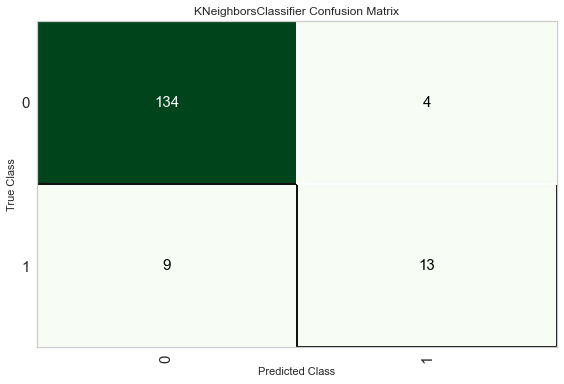

In [107]:
plot_model(tuned_models[2], plot='confusion_matrix')

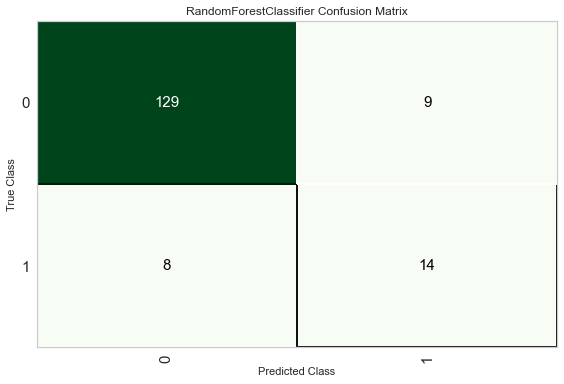

In [108]:
plot_model(tuned_models[3], plot='confusion_matrix')

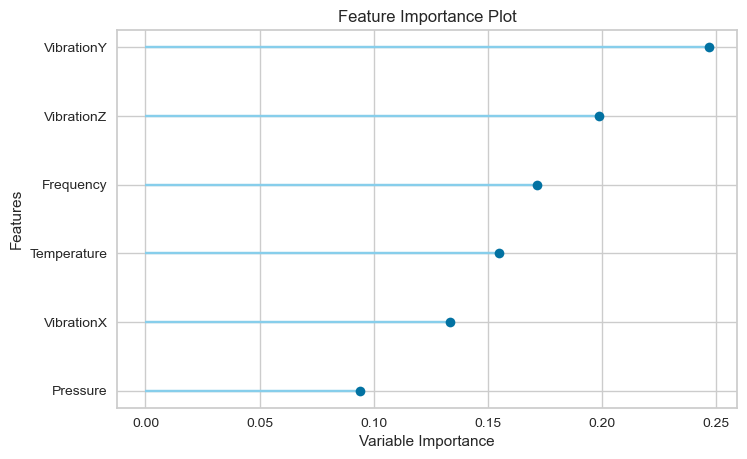

In [109]:
plot_model(tuned_models[3], plot='feature')

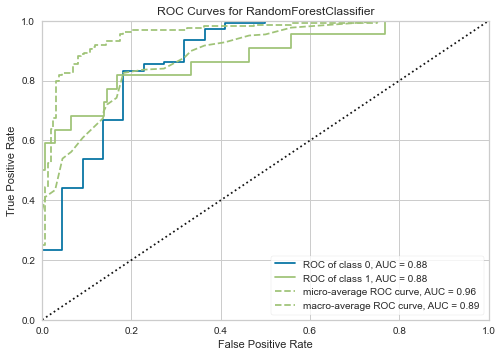

In [110]:
plot_model(tuned_models[3], plot='auc', verbose=False)

#### 2.1.3.4 - To Analyze Later

In [111]:
# Here another aprouche could be used. Instead of choosing just one cycle period before failure,
# multiple periods preceding the failure could be used. Thus, a multi-class classification approach 
# could be employed, especially if the system has multiple causes of failure.

In [112]:
# Treatments such as balancing the target and exploring other cross-validation strategies could be employed
# here. It is noteworthy that in this approach, a random holdout sample was used to separate a train and 
# test set in the proportion 0.8 and 0.2, respectively. The train set is used as a validator in the 
# cross-validation process during training and exploration of hyperparameter spaces.

## 2.2 - Proposing Predictive Models 

### 2.2.1 - Regression to identify time remaining until failures

In [113]:
# Overall, the Lasso regression model was the best linear solution to the proposed problem, even more
# for its explicit mathematical solution and the advantages of its l1 regularization, which tends to 
# prefer solutions with fewer non-zero coefficients, effectively reducing the number of features upon 
# which the given solution is dependent. Lasso's regression, always tended to favor the features of 
# vibrational parameters, pressure, frequency and temperature.
# However, when exploring Random Tree models, a better fit was observed in the Real vs. Predicted in 
# near-fail cycles (t_fail = 0). Therefore, a model of this type is proposed for the regressive task.

In [114]:
from pycaret.regression import *
env_model = setup(data = df[parameter + setups + ['t_fail']],  target = 't_fail', train_size = .8,
                 fold = 10, categorical_features = setups, normalize = True,
                 normalize_method = 'zscore', fold_strategy = 'kfold', session_id = 4321, silent = True)

In [115]:
# The R2 coefficient is chosen to tune and evaluate the regressive model. The use of this metric is 
# justified when seeking explanation of variables and understanding of system features.
# The RMSE and MAE metrics are also tracked in this process.

In [116]:
regressive_model = tune_model(create_model('rf'), optimize='R2')

In [117]:
regressive_model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=8, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.001,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=210, n_jobs=-1, oob_score=False,
                      random_state=4321, verbose=0, warm_start=False)

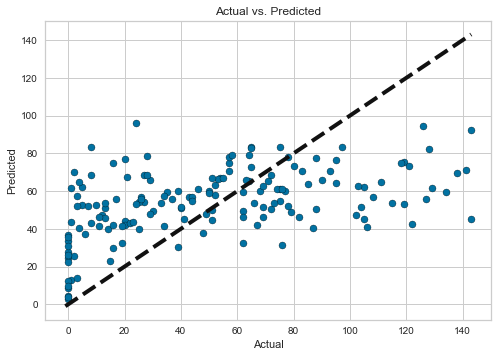

In [119]:
# Metrics and graphical analysis of projections in the test set
plot_test_validation_prediction(predict_model(regressive_model))

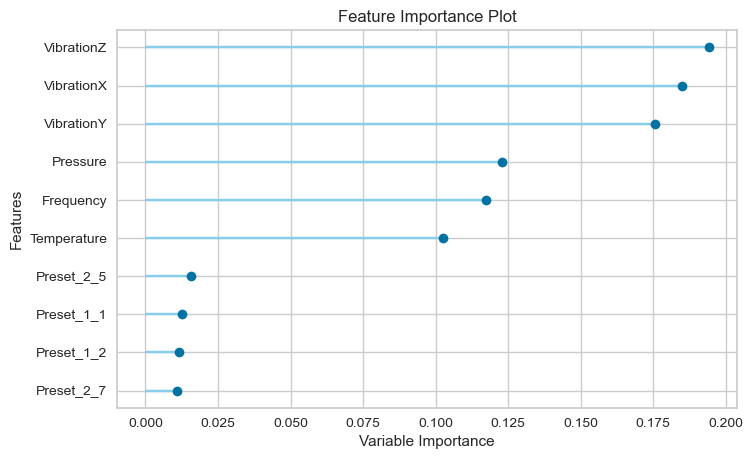

In [121]:
plot_model(regressive_model, plot='feature')

### 2.2.2 - Classification to identify if a machine is within 5 cycles to fail

In [122]:
# For the classification approach, tree-based models were able to better describe the proposed system. 
# At times, distance-based algorithms (KNN type) also performed well. As much as the 5 cycle interval was
# chosen, others could be tested. Here, the F1 metric was the most followed, as both Recall and Precision 
# are important to us. We want to generalize and cover as much as possible the failure event (Recall) and 
# be assent in the event indication (Precision). The confusion matrix and the performance of other metrics 
# are also indicated for the test set. Here, the Random Forest model is chosen in the simplest context, 
# where only numerical variables are used.

In [123]:
# Creation of new target
last_cycles = 5

df['target_last_5'] = np.where(df.t_fail <= last_cycles, 1, 0 )
df.target_last_5.value_counts()

from pycaret.classification import *
env_model = setup(data = df[parameter + ['target_last_5']],  target = 'target_last_5', train_size = .8,
                 fold = 10, categorical_features = [], normalize = True , fold_strategy = 'kfold', 
                  session_id = 421, silent = True, verbose=True, feature_selection = True)

In [124]:
# F1 metric optimized training
classification_model = tune_model(create_model('rf'), optimize='F1')

In [125]:
classification_model

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0001, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=False, random_state=421, verbose=0,
                       warm_start=False)

In [126]:
# Test prediction
predict_model(classification_model)

VibrationZ  Temperature  Pressure  VibrationX  VibrationY  Frequency  \
0     -0.424039     0.177280  1.110103   -0.420720   -0.387460   0.753129   
1      0.651170     0.890472 -0.224294    0.524851    1.755731   1.354759   
2     -0.234809     1.122795  0.368964    1.805523   -0.864511  -0.489976   
3      0.177595     0.457094  0.025769   -0.161978    1.911075   0.720225   
4     -0.580010    -0.522593 -0.723199   -0.565020    0.385373  -1.283779   
..          ...          ...       ...         ...         ...        ...   
155    0.252521    -0.989456 -1.266703   -1.109801   -0.299476  -0.888927   
156   -1.010167     0.291099 -0.441771   -0.898553    0.579958   0.734365   
157   -0.249723    -1.034573 -0.957633   -0.255226   -0.685043  -0.919146   
158    0.093117    -0.481244  0.187035    0.963527    1.241248  -0.534700   
159    0.613906     2.042939  2.823134    0.810469    1.453859   0.878398   

     target_last_5  Label   Score  
0                0      0  0.9817  
1                0      1  0.8134  
2                0      0  0.7641  
3                0      1  0.6636  
4                0      0  0.9453  
..             ...    ...     ...  
155              0      0  0.9097  
156              0      0  0.9980  
157              1      0  0.8771  
158              0      0  0.8884  
159              1      1  0.9071  

[160 rows x 9 columns]

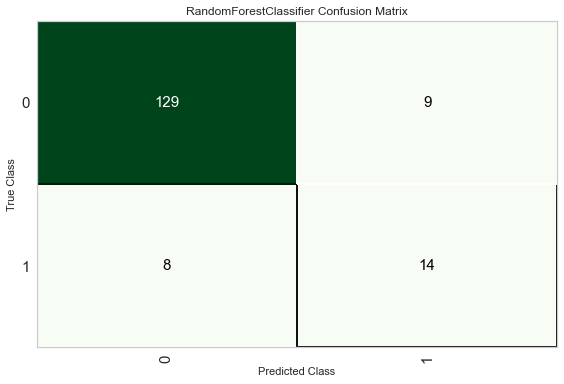

In [127]:
plot_model(classification_model, plot = 'confusion_matrix')

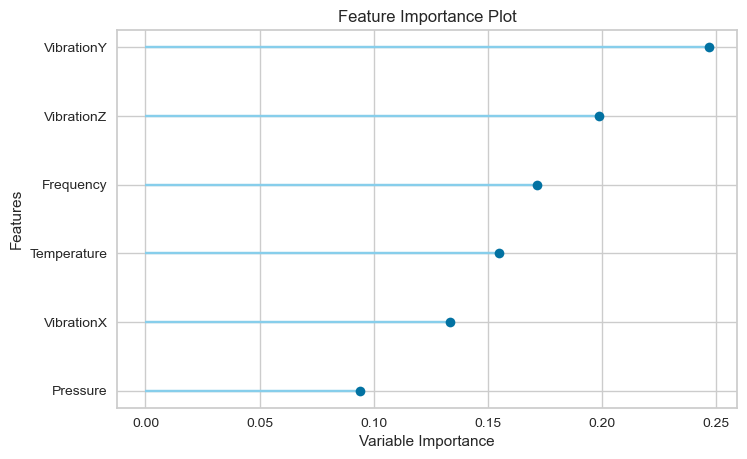

In [128]:
plot_model(classification_model, plot = 'feature')

In [129]:
# Instead of using a random training and test set, a test set using more recent failure 
# cycles should also be tested.

# 3 - Issues Indicator

## 3.1 - Calculate how many times the equipment has failed 

In [130]:
# Answered in section 1.3. There were 10 failures, considering that consecutive failures 
# in relation to the variable cycle represent the continuation of 1 failure.

## 3.2 - Categorize equipment failures by setups configurations (preset 1 and preset 2)

In [131]:
# The entire section 1.5 should be considered for this answer. In that section each step is detailed.

## 3.3 - Categorize equipment failures by their nature/root cause according to parameter readings (temperature, pressure, and others)

In [132]:
# This question and the previous one require statistical and graphical analysis and conclusions. 
# In this way, Sections 1.2, 1.4 and 1.6 were constructed to answer this question.

## 3.4 - Create a model using the technique you think is most appropriate and measure its performance

In [133]:
# According to the topics required in the Case, predictive models were built using two approaches, one 
# regressive and the other classificatory. The regressive approach would be the most ideal as it would 
# be more useful to predict the time when a failure is approaching. Thus, an adjustment of the 
# time before fail curve (t_fail) was guided by the metric R^2. It was chosen because it is expected to 
# identify variables related to information gain in the system. Several considerations were evaluated and 
# the one presented in Section 2.2.1 was chosen. As can be concluded from the metrics and the Predicted 
# vs. Real, the regressive approach was not satisfactory. A distribution very close to the dotted line 
# was not observed in Precited vs. Real, mainly in values close to zero.

In [134]:
# In the classification approach, it was aimed to find a predictive model to identify a period that 
# precedes a failure. To evaluate the model, the F1 metric was further explored, as discussed in 
# Section 2.2.2. For this model, decision trees ensemble approach was explored the most throughout 
# Section 2.1.3. Another very interesting proposed approach is mentioned in Section 2.1.3.4. Thus, I 
# indicate the technique presented in Section 2.2.2, as the chosen one. This model was able to identify 
# most of the failures for the test holdout random set, as can be identified by a Recall of 0.64. 
# This percentage is achieved while maintaining an precision of 0.61. An interesting point of this 
# approach is that it was built simply using vibrations, frequency, temperature and pressure.

## 3.5 – Analyze variable importance

In [135]:
# From the exploratory analysis of the data, the vibrations gave clues that would be crucial to identify 
# the failure event. Both in the regression model and in the classification model, the gain of information 
# was observed mainly in the vibrational parameters. In all directions, vibrational parameters appear 
# among the most important features. In the regressive model, the Z and X directions have more weight at 
# times of failure. In the classification model, the Y and Z directions are more important. The ranking of 
# the most important variables appears in the graphs in Section 2.2. Given the chosen model and the other 
# parameters, the temperature, frequency and pressure follow this order in the information gain.

# 4 - Feel free to add discussions about how you think you would put the models in production

In [136]:
# Several notes and ideas were indicated in the development of this Case. However, to improve the model,
# other approaches could be tested, as mentioned in Section 2. An improvement is expected in relation to 
# the increase in the number of data. More sensors could be incorporated into the system, looking for also
# significant parameters. A deployment in AWS would be very interesting, as it would allow easy integration
# with new data (new Cycles) from distant stations. New failures would allow new training and new cycles 
# would allow new scoring. An Anomaly Detection system would also work well for real-time anomaly 
# identification. Similar equipment could be grouped together and used to train more generic models
# with more data.

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0